##Hugging Face Transformers for AutoTokenizer and CodeBERT

In [ ]:
!pip install transformers

##Tree-sitter for Syntax-aware Tokenization

In [5]:
!pip install tree-sitter-language-pack

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.6/634.6 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 9.5 MB/s eta 0:00:00


##Build solidity parser

In [6]:
from tree_sitter_language_pack import get_language, get_parser

solidity_lang = get_language("solidity")
parser = get_parser("solidity")


##Parsing Solidity code into tokens

In [304]:
import os
import pandas as pd

def parsing_code(path_to_files):
  token_list = []
  vuln_type = []
  #df = pd.DataFrame(list, columns=['path', 'tokens'])
  dir_path = os.path.dirname(path_to_files)
  for file_name in os.listdir(dir_path):
    if file_name.endswith(".sol"):
      vuln_type.append(file_name)
      file_path = os.path.join(dir_path, file_name)
      if os.path.isfile(file_path):
          with open(file_path, 'r', encoding='utf-8') as f:
            #print(file_path)
              code = f.read()
              code_bytes = bytes(code, 'utf-8')
              tree = parser.parse(code_bytes)
              unclean_tokens = extract_tokens(tree.root_node, code_bytes)
             # merge_risky_member_access(unclean_tokens)
              clean_token = clean_tokens(unclean_tokens)
              token_list.append(clean_token)

              #df.loc[len(df)] = [file_path, clean_token]
  return token_list, vuln_type



##Extracting tokens from solidity code

In [305]:
def extract_tokens(node, code):
    tokens = []
    if node.child_count == 0:
        token_text = code[node.start_byte:node.end_byte].decode('utf-8')
        tokens.append((node.type, token_text))
    for child in node.children:
        tokens.extend(extract_tokens(child, code))
    return tokens

##Clean tokens

In [306]:
import re

def clean_tokens(unclean_tokens):
  clean_tokens = []
  for token_type, token_value in unclean_tokens:
    if token_type == "identifier":
      clean_tokens.append(token_value)
    elif token_type in ["mapping","address",".","public","private","internal", "constructor","function","contract","payable","external","bool","ether"] or token_value.startswith("uint"):
      clean_tokens.append(token_value)
  return clean_tokens

In [307]:
def merge_risky_member_access(token_lists):
    """
    Merge only known risky Solidity member accesses into single tokens.
    Example: ['block', '.', 'timestamp'] -> ['block.timestamp']
             ['tx', '.', 'origin'] -> ['tx.origin']

    Args:
        token_lists (list[list[str]]): tokenized Solidity files from Tree-sitter.

    Returns:
        list[list[str]]: token lists with risky member accesses merged.
    """
    # Known risky patterns from OWASP Top 10 + common insecure sources
    risky_patterns = {
        ("block", "timestamp"),
        ("block", "difficulty"),
        ("block", "number"),      # sometimes used in RNG
        ("tx", "origin"),         # access control vulnerability
        ("msg", "value"),         # unchecked value transfer
        ("msg", "sender"),        # not always bad, but often relevant in auth
        ("address", "call"),      # low-level call
        ("address", "delegatecall"),
        ("address", "staticcall")
    }

    merged_all_files = []

    for tokens in token_lists:
        merged_tokens = []
        i = 0
        while i < len(tokens):
            if (
                i + 2 < len(tokens)
                and tokens[i+1] == "."
                and (tokens[i], tokens[i+2]) in risky_patterns
            ):
                merged_tokens.append(tokens[i] + "." + tokens[i+2])
                i += 3
            else:
                merged_tokens.append(tokens[i])
                i += 1
        merged_all_files.append(merged_tokens)
        #print("merged files",merged_all_files)

    return merged_all_files


In [308]:

vuln_tokens,owasp = parsing_code("/home/OWASP/vulnerable/")
print(vuln_tokens)
#vuln_tokens = merge_risky_member_access(vuln_tokens)

#fixed_tokens, = parsing_code("/home/OWASP/fixed/")
#fixed_tokens = merge_risky_member_access(fixed_tokens)


[['contract', 'Solidity_InsecureRandomness', 'constructor', 'payable', 'function', 'guess', 'uint256', '_guess', 'public', 'uint256', 'answer', 'uint256', 'keccak256', 'abi', '.', 'encodePacked', 'block', '.', 'timestamp', 'block', '.', 'difficulty', 'msg', '.', 'sender', '_guess', 'answer', 'bool', 'sent', 'msg', '.', 'sender', '.', 'call', 'value', 'ether', 'require', 'sent'], ['contract', 'Solidity_AccessControl', 'mapping', 'address', 'uint256', 'public', 'balances', 'function', 'burn', 'address', 'account', 'uint256', 'amount', 'public', '_burn', 'account', 'amount'], ['contract', 'Solidity_UncheckedExternalCall', 'address', 'public', 'owner', 'constructor', 'public', 'owner', 'msg', '.', 'sender', 'function', 'forward', 'address', 'callee', '_data', 'public', 'require', 'callee', '.', 'delegatecall', '_data'], ['IPriceFeed', 'function', 'getLatestPrice', 'external', 'contract', 'PriceOracleManipulation', 'address', 'public', 'owner', 'IPriceFeed', 'public', 'priceFeed', 'construc

In [309]:
def tokens_to_string(list_of_token_lists):
  return [" ".join(word) for word in list_of_token_lists]


In [310]:
import numpy as np

vuln_token = tokens_to_string(vuln_tokens)
fixed_token = tokens_to_string(fixed_tokens)
docs = vuln_token + fixed_token
labels = np.array([0] * len(vuln_token) + [1] * len(fixed_token))

In [311]:
print(owasp)

['insecure_randomness.sol', 'access_control.sol', 'unchecked_external_calls.sol', 'price_oracle_manipulation.sol', 'reentrance_attacks.sol', 'dos.sol', 'integer_overunder_flow.sol', 'logic_errors.sol', 'lack_input_validation.sol']


In [312]:
df = pd.DataFrame({'vuln_tokes': vuln_token, 'fixed_tokens':fixed_token,'vuln_type':owasp})
df

,vuln_tokes,fixed_tokens,vuln_type
0,contract Solidity_InsecureRandomness construct...,contract Solidity_LogicErrors mapping address ...,insecure_randomness.sol
1,contract Solidity_AccessControl mapping addres...,IPriceFeed function getLatestPrice external co...,access_control.sol
2,contract Solidity_UncheckedExternalCall addres...,contract LackOfInputValidation mapping address...,unchecked_external_calls.sol
3,IPriceFeed function getLatestPrice external co...,contract Solidity_DOS address public king uint...,price_oracle_manipulation.sol
4,contract Solidity_Reentrancy mapping address u...,contract Solidity_InsecureRandomness VRFConsum...,reentrance_attacks.sol
5,contract Solidity_DOS address public king uint...,contract Solidity_OverflowUnderflow uint8 publ...,dos.sol
6,contract Solidity_OverflowUnderflow uint8 publ...,contract Solidity_AccessControl Ownable mappin...,integer_overunder_flow.sol
7,contract Solidity_LogicErrors mapping address ...,contract Solidity_CheckedExternalCall address ...,logic_errors.sol
8,contract Solidity_LackOfInputValidation mappin...,contract Solidity_Reentrancy mapping address u...,lack_input_validation.sol


In [313]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer="word",
    token_pattern = r"\S+",
    lowercase=False,
    ngram_range=(1,1),
    max_df=1.0,
    min_df=1,
    max_features=None,
)


In [314]:
X = vectorizer.fit_transform(docs)
print("TF-IDF shape:", X.shape)


TF-IDF shape: (18, 100)


In [315]:

feature_names = np.array(vectorizer.get_feature_names_out())

# 4. Compute average TF-IDF per class
vuln_mean = X[labels == 0].mean(axis=0).A1
fixed_mean = X[labels == 1].mean(axis=0).A1

# 5. Get top N tokens for each class
N = 10
top_vuln_idx = np.argsort(vuln_mean - fixed_mean)[::-1][:N]
top_fixed_idx = np.argsort(fixed_mean - vuln_mean)[::-1][:N]

print("🔴 Top Vulnerable Tokens:")
for idx in top_vuln_idx:
    print(f"{feature_names[idx]}  ({vuln_mean[idx]:.4f})")

print("\n🟢 Top Fixed Tokens:")
for idx in top_fixed_idx:
    print(f"{feature_names[idx]}  ({fixed_mean[idx]:.4f})")

🔴 Top Vulnerable Tokens:
msg  (0.1890)
.  (0.2038)
sender  (0.1382)
value  (0.1229)
sent  (0.0612)
block  (0.0381)
answer  (0.0381)
Solidity_LackOfInputValidation  (0.0364)
Solidity_UncheckedExternalCall  (0.0299)
timestamp  (0.0190)

🟢 Top Fixed Tokens:
msg.sender  (0.1497)
msg.value  (0.0704)
onlyOwner  (0.0686)
success  (0.0790)
randomResult  (0.0438)
fee  (0.0438)
previousKing  (0.0393)
previousBalance  (0.0393)
owner  (0.1000)
Ownable  (0.0343)


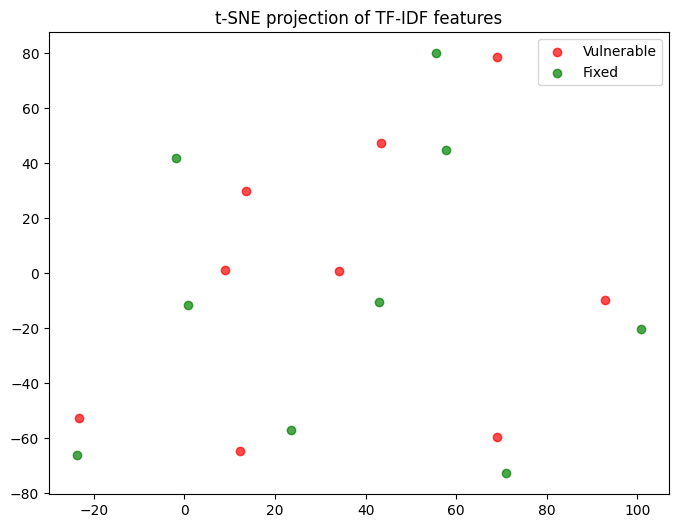

In [316]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from umap import UMAP  # optional if you want UMAP instead

# X = TF-IDF matrix from earlier, labels = 0 (vuln) / 1 (fixed)

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_2d = tsne.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_2d[labels==0,0], X_2d[labels==0,1], c='red', label='Vulnerable', alpha=0.7)
plt.scatter(X_2d[labels==1,0], X_2d[labels==1,1], c='green', label='Fixed', alpha=0.7)
plt.legend()
plt.title("t-SNE projection of TF-IDF features")
plt.show()


In [318]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut # Changed from LeavePGroupOut
from sklearn.metrics import accuracy_score

# Group IDs so each vuln/fixed pair is left out together
groups = list(range(len(vuln_token))) + list(range(len(fixed_token))) # Changed from vuln_strings and fixed_strings

clf = LogisticRegression(max_iter=1000)
logo = LeaveOneGroupOut() # Changed from LeavePGroupOut(n_groups=len(vuln_strings))

scores = []
# The groups parameter is not needed for LeaveOneGroupOut
for train_idx, test_idx in logo.split(X, labels, groups=groups):
    clf.fit(X[train_idx], labels[train_idx])
    preds = clf.predict(X[test_idx])
    scores.append(accuracy_score(labels[test_idx], preds))

print(f"Leave-One-Pair-Out Accuracy: {sum(scores)/len(scores):.2f}")

Leave-One-Pair-Out Accuracy: 0.39


In [320]:
import numpy as np

feature_names = np.array(vectorizer.get_feature_names_out())
coefs = clf.coef_[0]

top_vuln_idx = np.argsort(coefs)[::-1][:10]
top_fixed_idx = np.argsort(coefs)[:10]

print("🔴 Vulnerable-driving tokens:")
for idx in top_vuln_idx:
    print(f"{feature_names[idx]} ({coefs[idx]:.4f})")

print("\n🟢 Fixed-driving tokens:")
for idx in top_fixed_idx:
    print(f"{feature_names[idx]} ({coefs[idx]:.4f})")


🔴 Vulnerable-driving tokens:
msg.sender (0.3708)
onlyOwner (0.2521)
msg.value (0.2008)
user (0.1950)
randomResult (0.1580)
fee (0.1580)
previousBalance (0.1484)
previousKing (0.1484)
Ownable (0.1395)
address (0.1187)

🟢 Fixed-driving tokens:
msg (-0.6562)
. (-0.5533)
sender (-0.4804)
value (-0.2134)
sent (-0.1479)
answer (-0.1236)
block (-0.1236)
Solidity_UncheckedExternalCall (-0.1227)
call (-0.0965)
uint (-0.0906)
